## 誘導式深度學習 (Highlighted DL) 效果在 TensorFlow + Keras 上的實證

### 實驗背景
　　這是基於我的碩士論文「以誘導式深度學習為基礎之配藥核實技術及應用」所延伸的實驗（多國發明專利申請中，論文未公開）。在原始論文裡，我採用了 YOLO v2、ResNet 與 SE-ResNet 三種網路，證明「誘導式深度學習」能有效解決**訓練樣本稀少**、**藥物外觀相似**與**藥物種類繁多**等藥物識別上的難題，不但將藥物辨識率從 86% 提升至 99.8%，更採用 NVIDIA® Jetson TX2 嵌入式系統與模型結構優化技術，實現 6.23 幀 / 秒的實時藥物識別產品雛型。

　　由於 YOLO v2、ResNet 與 SE-ResNet 皆屬較龐大的網路，所以，為了證明「誘導式深度學習」在簡單的 CNN 網路上**也能有卓越的識別率優化效果**，我將使用論文中未出現的 TensorFlow 與 Keras 框架重新進行實驗，也就是接下來這份文件中的內容。


### 數據說明
　　這項實驗所採用的數據與原始論文相同：成人錠劑**排藥包裝 (Blister Package)** 共 250 類，每個類別正、反面各 72 張，總計 36,000 張影像。對了！這是一份公開數據集，您可以在 [Google Drive](https://drive.google.com/folderview?id=1cV7JVYGRxcm9DY0o7BMJHTCRdo_RW17n) 或 [Baidu Pan](https://pan.baidu.com/s/1amfARVIhGIfYVIIfB9qFRg) 下載，供學術研究與非商業性質的實驗使用。


### 實驗說明
　　與原始論文相同，我將使用排藥的 **1. 正面原始影像**、**2. 背面原始影像**，與經過「誘導式深度學習」技術生成的 **3. 雙面拼整影像**資料集，對相同的 CNN 網路進行訓練與測試，目的在於觀察「誘導式深度學習」技術的採用與否，對排藥識別效果的影響會有多大。
  
　　在訓練樣本、測試樣本的分配上，將依照 3:1 的比例，對每類別 72 張圖像**隨機抽取** 54 張作為訓練集 (Training-set)、18 張作為測試集 (Testing-set)，總計訓練樣本 13,500 張，訓練樣本外 (Out-of-sample) 的測試樣本 4,500 張。訓練時，還會從每類別 54 張訓練圖像中再**隨機抽取** 18 張作為驗證集 (Validation-set)。
  
　　介紹完了，我們開始吧！

---

## Step 1. 環境參數設定
設置載入的套件與資料集路徑。在本實驗中，我將採用 150 x 150 的圖像輸入尺寸進行模型的訓練與測試，而非原始論文的 224 x 224。

In [1]:
import os, shutil
import keras
from keras import layers
from keras import models
from keras import regularizers
from keras import optimizers
from keras.layers.core import Dropout
import matplotlib.pyplot as plt
import numpy as np

image_size = 150

# 正面原始影像的訓練與測試圖像路徑。
front_train_dir = "/home/ubuntu/Desktop/High/OriginalFrontTrain"
front_test_dir = "/home/ubuntu/Desktop/High/OriginalFrontTest"

# 背面原始影像的訓練與測試圖像路徑。
back_train_dir = "/home/ubuntu/Desktop/High/OriginalBackTrain"
back_test_dir = "/home/ubuntu/Desktop/High/OriginalBackTest"

# 雙面拼整影像的訓練與測試圖像路徑。
high_train_dir = "/home/ubuntu/Desktop/High/HighlightedTrain"
high_test_dir = "/home/ubuntu/Desktop/High/HighlightedTest"

Using TensorFlow backend.


## Step 2. 建立簡單的 CNN 模型（三種資料集都使用相同的模型結構）
卷積神經網路中採用 Dropout 防止數據過擬合；最後一個全連接層使用 Softmax 作為激活函數，對 250 種排藥類別進行預測。

In [2]:
# 訓練與識別正面原始影像的模型
model_front = models.Sequential()
model_front.add(layers.Conv2D(16, (3, 3), activation = 'relu', input_shape = (image_size, image_size, 3)))
model_front.add(layers.MaxPooling2D((2, 2)))
model_front.add(Dropout(0.25))
model_front.add(layers.Conv2D(32, (3, 3), activation = 'relu'))
model_front.add(layers.MaxPooling2D((2, 2)))
model_front.add(Dropout(0.25))
model_front.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model_front.add(layers.MaxPooling2D((2, 2)))
model_front.add(Dropout(0.25))
model_front.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model_front.add(layers.MaxPooling2D((2, 2)))
model_front.add(Dropout(0.25))

model_front.add(layers.Flatten())
model_front.add(layers.Dense(128, activation = 'relu'))
model_front.add(Dropout(0.5))
model_front.add(layers.Dense(250, activation = 'softmax'))


# 訓練與識別背面原始影像的模型
model_back = models.Sequential()
model_back.add(layers.Conv2D(16, (3, 3), activation = 'relu', input_shape = (image_size, image_size, 3)))
model_back.add(layers.MaxPooling2D((2, 2)))
model_back.add(Dropout(0.25))
model_back.add(layers.Conv2D(32, (3, 3), activation = 'relu'))
model_back.add(layers.MaxPooling2D((2, 2)))
model_back.add(Dropout(0.25))
model_back.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model_back.add(layers.MaxPooling2D((2, 2)))
model_back.add(Dropout(0.25))
model_back.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model_back.add(layers.MaxPooling2D((2, 2)))
model_back.add(Dropout(0.25))

model_back.add(layers.Flatten())
model_back.add(layers.Dense(128, activation = 'relu'))
model_back.add(Dropout(0.5))
model_back.add(layers.Dense(250, activation = 'softmax'))


# 訓練與識別雙面拼整影像的模型
model_high = models.Sequential()
model_high.add(layers.Conv2D(16, (3, 3), activation = 'relu', input_shape = (image_size, image_size, 3)))
model_high.add(layers.MaxPooling2D((2, 2)))
model_high.add(Dropout(0.25))
model_high.add(layers.Conv2D(32, (3, 3), activation = 'relu'))
model_high.add(layers.MaxPooling2D((2, 2)))
model_high.add(Dropout(0.25))
model_high.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model_high.add(layers.MaxPooling2D((2, 2)))
model_high.add(Dropout(0.25))
model_high.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model_high.add(layers.MaxPooling2D((2, 2)))
model_high.add(Dropout(0.25))

model_high.add(layers.Flatten())
model_high.add(layers.Dense(128, activation = 'relu'))
model_high.add(Dropout(0.5))
model_high.add(layers.Dense(250, activation = 'softmax'))


# 看看模型長什麼樣子
model_high.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 34, 34, 64)        18496     
__________

## Step 3. 編譯模型
使用 'categorical_crossentropy' 作為損失函數，讓「網路輸出」的機率分佈與「真實標籤」的分佈盡可能一致。

In [3]:
model_front.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

model_back.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

model_high.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

## Step 4. 採用 Generator 批量生成訓練與驗證資料
使用驗證資料集來確認該在何時執行 Early Stopping，以便稍後（Step 8）選用最佳模型進行測試資料集的效果評估。

資料總計：訓練樣本 9,000 張影像、驗證樣本 4,500 張影像，共 250 類。

In [4]:
from keras.preprocessing.image import ImageDataGenerator

# 從同一個 training 資料路徑下拆分出 training 與 validation 的數據集。
# 設定 validation_split=0.35，從每類 54 張訓練樣本中抽取 18 張作為驗證樣本。

data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.35)

# 正面原始影像的 Generator

print("Status of front images:")

print("[Training set]")

front_train_gen = data_generator.flow_from_directory(
        front_train_dir,
        target_size = (image_size, image_size),
        shuffle = True,
        seed = 13,
        class_mode = 'categorical', # 多類別，所以使用 categorical 標籤，返回 2D 的 one-hot 編碼標籤。
        batch_size = 36,
        subset = "training") # 因為啟用了 validation_split，故可設定 train_generator 放的是「訓練子集」。

print("[Validation set]")

front_validation_gen = data_generator.flow_from_directory(
        front_train_dir, # 一樣從 training 的路徑下抓取驗證用數據。
        target_size = (image_size, image_size),
        shuffle = True,
        seed = 13,
        class_mode = 'categorical',
        batch_size = 36,
        subset = "validation") # 因為啟用了 validation_split，故可設定 validation_generator 放的是「驗證子集」。

# 背面原始影像的 Generator

print("\nStatus of back images:")

print("[Training set]")

back_train_gen = data_generator.flow_from_directory(
        back_train_dir,
        target_size = (image_size, image_size),
        shuffle = True,
        seed = 13,
        class_mode = 'categorical',
        batch_size = 36,
        subset = "training")

print("[Validation set]")

back_validation_gen = data_generator.flow_from_directory(
        back_train_dir,
        target_size = (image_size, image_size),
        shuffle = True,
        seed = 13,
        class_mode = 'categorical',
        batch_size = 36,
        subset = "validation")

# 雙面拼整影像的 Generator

print("\nStatus of highlighted images:")

print("[Training set]")

high_train_gen = data_generator.flow_from_directory(
        high_train_dir,
        target_size = (image_size, image_size),
        shuffle = True,
        seed = 13,
        class_mode = 'categorical',
        batch_size = 36,
        subset = "training")

print("[Validation set]")

high_validation_gen = data_generator.flow_from_directory(
        high_train_dir,
        target_size = (image_size, image_size),
        shuffle = True,
        seed = 13,
        class_mode = 'categorical',
        batch_size = 36,
        subset = "validation")

Status of front images:
[Training set]
Found 9000 images belonging to 250 classes.
[Validation set]
Found 4500 images belonging to 250 classes.

Status of back images:
[Training set]
Found 9000 images belonging to 250 classes.
[Validation set]
Found 4500 images belonging to 250 classes.

Status of highlighted images:
[Training set]
Found 9000 images belonging to 250 classes.
[Validation set]
Found 4500 images belonging to 250 classes.


## Step 5. 定義 Callback Function 以計算 Percision / Recall / F1-Score
同原始論文，我們將以 Precision、Recall 與 F1-Score 作為實驗的評估標準。

然而，我們不能使用 Keras 內建的矩陣函式（Metric function）進行 F1-Score 的計算！因為矩陣函式是根據 Batch Step 進行呼叫的，其所計算的 F1-score 將只是該 Batch 的平均結果，而不是每個 Epoch 的平均結果。

此外，若要透過 Data Generator 來計算 F1-Score，我們必須自行設計對應的 Callback 函式。

### 參考資料
* https://medium.com/@thongonary/how-to-compute-f1-score-for-each-epoch-in-keras-a1acd17715a2
* https://github.com/keras-team/keras/issues/10472#issuecomment-472543538

In [5]:
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import warnings
import sklearn.exceptions

warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

# 紀錄每個 Epoch 訓練結束時，使用驗證集測試得到的 F1-score 結果
front_f1s = []
back_f1s = []
high_f1s = []

class MetricsFront(Callback):

    def __init__(self, val_data = front_validation_gen, batch_size = 36):
        super().__init__()
        self.validation_data = val_data
        self.batch_size = batch_size
        
    def on_epoch_end(self, epoch, logs={}):
        batches = len(self.validation_data)
        total = batches * self.batch_size
        
        val_pred = np.zeros((total, 250))
        val_true = np.zeros((total, 250))
        
        for batch in range(batches):
            xVal, yVal = next(self.validation_data)
            val_pred[batch * self.batch_size : (batch + 1) * self.batch_size] = np.asarray(self.model.predict(xVal)).round()
            val_true[batch * self.batch_size : (batch + 1) * self.batch_size] = yVal
            
        val_pred = np.squeeze(val_pred)
        _val_f1 = f1_score(val_true, val_pred, average = 'micro')
        _val_precision = precision_score(val_true, val_pred, average = 'micro')
        _val_recall = recall_score(val_true, val_pred, average = 'micro')
        
        front_f1s.append(_val_f1)

        print("- val_f1: %f - val_precision: %f - val_recall: %f"%(_val_f1, _val_precision, _val_recall))
        return
    
class MetricsBack(Callback):

    def __init__(self, val_data = back_validation_gen, batch_size = 36):
        super().__init__()
        self.validation_data = val_data
        self.batch_size = batch_size
        
    def on_epoch_end(self, epoch, logs={}):
        batches = len(self.validation_data)
        total = batches * self.batch_size
        
        val_pred = np.zeros((total, 250))
        val_true = np.zeros((total, 250))
        
        for batch in range(batches):
            xVal, yVal = next(self.validation_data)
            val_pred[batch * self.batch_size : (batch + 1) * self.batch_size] = np.asarray(self.model.predict(xVal)).round()
            val_true[batch * self.batch_size : (batch + 1) * self.batch_size] = yVal
            
        val_pred = np.squeeze(val_pred)
        _val_f1 = f1_score(val_true, val_pred, average = 'micro')
        _val_precision = precision_score(val_true, val_pred, average = 'micro')
        _val_recall = recall_score(val_true, val_pred, average = 'micro')
        
        back_f1s.append(_val_f1)
        
        print("- val_f1: %f - val_precision: %f - val_recall: %f"%(_val_f1, _val_precision, _val_recall))
        return
    
class MetricsHigh(Callback):

    def __init__(self, val_data = high_validation_gen, batch_size = 36):
        super().__init__()
        self.validation_data = val_data
        self.batch_size = batch_size
        
    def on_epoch_end(self, epoch, logs={}):
        batches = len(self.validation_data)
        total = batches * self.batch_size
        
        val_pred = np.zeros((total, 250))
        val_true = np.zeros((total, 250))
        
        for batch in range(batches):
            xVal, yVal = next(self.validation_data)
            val_pred[batch * self.batch_size : (batch + 1) * self.batch_size] = np.asarray(self.model.predict(xVal)).round()
            val_true[batch * self.batch_size : (batch + 1) * self.batch_size] = yVal
            
        val_pred = np.squeeze(val_pred)
        _val_f1 = f1_score(val_true, val_pred, average = 'micro')
        _val_precision = precision_score(val_true, val_pred, average = 'micro')
        _val_recall = recall_score(val_true, val_pred, average = 'micro')
        
        high_f1s.append(_val_f1)
        
        print("- val_f1: %f - val_precision: %f - val_recall: %f"%(_val_f1, _val_precision, _val_recall))
        return

## Step 6. 訓練與驗證深度學習網路
此部分定義了訓練的資料路徑、訓練與驗證集的相關參數，以及要呼叫的 Callback Function。

與原始論文相同，我將以 100 次的 Epoch 進行訓練，並透過驗證集來尋找 Early Stopping 的時機。

In [6]:
print("Front images training:")

model_front.fit_generator(
    front_train_gen,
    steps_per_epoch = 250,
    epochs = 100,
    validation_data = front_validation_gen,
    validation_steps = 125,
    callbacks = [MetricsFront()])

print("\nBack images training:")

model_back.fit_generator(
    back_train_gen,
    steps_per_epoch = 250,
    epochs = 100,
    validation_data = back_validation_gen,
    validation_steps = 125,
    callbacks = [MetricsBack()])

print("\nHighlighted images training:")

model_high.fit_generator(
    high_train_gen,
    steps_per_epoch = 250,
    epochs = 100,
    validation_data = high_validation_gen,
    validation_steps = 125,
    callbacks = [MetricsHigh()])

Front images training:
Epoch 1/100
250/250 [==============================] - 141s 562ms/step - loss: 5.4337 - acc: 0.0054 - val_loss: 5.2365 - val_acc: 0.0113
- val_f1: 0.000000 - val_precision: 0.000000 - val_recall: 0.000000
Epoch 2/100
250/250 [==============================] - 123s 492ms/step - loss: 5.0433 - acc: 0.0196 - val_loss: 4.6882 - val_acc: 0.0447
- val_f1: 0.000000 - val_precision: 0.000000 - val_recall: 0.000000
Epoch 3/100
250/250 [==============================] - 123s 492ms/step - loss: 4.5510 - acc: 0.0473 - val_loss: 4.2991 - val_acc: 0.0904
- val_f1: 0.007086 - val_precision: 1.000000 - val_recall: 0.003556
Epoch 4/100
250/250 [==============================] - 123s 492ms/step - loss: 4.0916 - acc: 0.0831 - val_loss: 3.6843 - val_acc: 0.2018
- val_f1: 0.027181 - val_precision: 1.000000 - val_recall: 0.013778
Epoch 5/100
250/250 [==============================] - 123s 492ms/step - loss: 3.7069 - acc: 0.1339 - val_loss: 3.2694 - val_acc: 0.2584
- val_f1: 0.061479 -

250/250 [==============================] - 124s 496ms/step - loss: 1.1685 - acc: 0.6612 - val_loss: 1.2499 - val_acc: 0.6402
- val_f1: 0.605237 - val_precision: 0.833528 - val_recall: 0.475111
Epoch 42/100
250/250 [==============================] - 123s 493ms/step - loss: 1.1648 - acc: 0.6639 - val_loss: 1.0784 - val_acc: 0.6998
- val_f1: 0.657429 - val_precision: 0.859089 - val_recall: 0.532444
Epoch 43/100
250/250 [==============================] - 123s 492ms/step - loss: 1.1616 - acc: 0.6654 - val_loss: 1.5219 - val_acc: 0.5969
- val_f1: 0.607872 - val_precision: 0.776702 - val_recall: 0.499333
Epoch 44/100
250/250 [==============================] - 123s 493ms/step - loss: 1.1753 - acc: 0.6621 - val_loss: 1.3524 - val_acc: 0.6167
- val_f1: 0.612332 - val_precision: 0.764041 - val_recall: 0.510889
Epoch 45/100
250/250 [==============================] - 123s 492ms/step - loss: 1.1864 - acc: 0.6596 - val_loss: 1.8589 - val_acc: 0.4893
- val_f1: 0.460401 - val_precision: 0.750754 - val_

250/250 [==============================] - 122s 490ms/step - loss: 1.2487 - acc: 0.6707 - val_loss: 1.7525 - val_acc: 0.5498
- val_f1: 0.534749 - val_precision: 0.704578 - val_recall: 0.430889
Epoch 82/100
250/250 [==============================] - 124s 495ms/step - loss: 1.2358 - acc: 0.6744 - val_loss: 2.0620 - val_acc: 0.5084
- val_f1: 0.479102 - val_precision: 0.649430 - val_recall: 0.379556
Epoch 83/100
250/250 [==============================] - 125s 498ms/step - loss: 1.2572 - acc: 0.6740 - val_loss: 2.0521 - val_acc: 0.4804
- val_f1: 0.430168 - val_precision: 0.635534 - val_recall: 0.325111
Epoch 84/100
250/250 [==============================] - 124s 498ms/step - loss: 1.2761 - acc: 0.6661 - val_loss: 1.7121 - val_acc: 0.5660
- val_f1: 0.553920 - val_precision: 0.750665 - val_recall: 0.438889
Epoch 85/100
250/250 [==============================] - 124s 495ms/step - loss: 1.2697 - acc: 0.6612 - val_loss: 1.7921 - val_acc: 0.5329
- val_f1: 0.507050 - val_precision: 0.693673 - val_

250/250 [==============================] - 134s 537ms/step - loss: 1.5740 - acc: 0.5492 - val_loss: 1.7070 - val_acc: 0.5249
- val_f1: 0.482094 - val_precision: 0.774336 - val_recall: 0.350000
Epoch 22/100
250/250 [==============================] - 136s 544ms/step - loss: 1.4794 - acc: 0.5667 - val_loss: 1.6133 - val_acc: 0.5504
- val_f1: 0.520218 - val_precision: 0.768796 - val_recall: 0.393111
Epoch 23/100
250/250 [==============================] - 136s 546ms/step - loss: 1.4255 - acc: 0.5858 - val_loss: 1.4098 - val_acc: 0.6024
- val_f1: 0.575610 - val_precision: 0.812146 - val_recall: 0.445778
Epoch 24/100
250/250 [==============================] - 135s 542ms/step - loss: 1.3644 - acc: 0.5949 - val_loss: 1.6839 - val_acc: 0.5378
- val_f1: 0.519841 - val_precision: 0.717527 - val_recall: 0.407556
Epoch 25/100
250/250 [==============================] - 137s 547ms/step - loss: 1.3245 - acc: 0.6053 - val_loss: 1.1799 - val_acc: 0.6656
- val_f1: 0.643497 - val_precision: 0.807447 - val_

250/250 [==============================] - 129s 516ms/step - loss: 0.9341 - acc: 0.7438 - val_loss: 1.1072 - val_acc: 0.6956
- val_f1: 0.692863 - val_precision: 0.806433 - val_recall: 0.607333
Epoch 62/100
250/250 [==============================] - 129s 516ms/step - loss: 0.9521 - acc: 0.7432 - val_loss: 1.0371 - val_acc: 0.7291
- val_f1: 0.716299 - val_precision: 0.816141 - val_recall: 0.638222
Epoch 63/100
250/250 [==============================] - 129s 516ms/step - loss: 0.9498 - acc: 0.7387 - val_loss: 1.4615 - val_acc: 0.6331
- val_f1: 0.573636 - val_precision: 0.865859 - val_recall: 0.428889
Epoch 64/100
250/250 [==============================] - 129s 515ms/step - loss: 0.9360 - acc: 0.7464 - val_loss: 1.1235 - val_acc: 0.7009
- val_f1: 0.678777 - val_precision: 0.799819 - val_recall: 0.589556
Epoch 65/100
250/250 [==============================] - 129s 515ms/step - loss: 0.9679 - acc: 0.7380 - val_loss: 2.0560 - val_acc: 0.5282
- val_f1: 0.517836 - val_precision: 0.649246 - val_

Epoch 1/100
250/250 [==============================] - 110s 439ms/step - loss: 5.4928 - acc: 0.0068 - val_loss: 5.2928 - val_acc: 0.0356
- val_f1: 0.003992 - val_precision: 1.000000 - val_recall: 0.002000
Epoch 2/100
250/250 [==============================] - 98s 393ms/step - loss: 4.8083 - acc: 0.0556 - val_loss: 3.9823 - val_acc: 0.1764
- val_f1: 0.056107 - val_precision: 0.970149 - val_recall: 0.028889
Epoch 3/100
250/250 [==============================] - 99s 394ms/step - loss: 3.7790 - acc: 0.1627 - val_loss: 2.8398 - val_acc: 0.4596
- val_f1: 0.202582 - val_precision: 0.953271 - val_recall: 0.113333
Epoch 4/100
250/250 [==============================] - 98s 393ms/step - loss: 2.8687 - acc: 0.3051 - val_loss: 1.7741 - val_acc: 0.6567
- val_f1: 0.440364 - val_precision: 0.966843 - val_recall: 0.285111
Epoch 5/100
250/250 [==============================] - 99s 395ms/step - loss: 2.2562 - acc: 0.4281 - val_loss: 1.3518 - val_acc: 0.7282
- val_f1: 0.568865 - val_precision: 0.975175 - 

250/250 [==============================] - 100s 399ms/step - loss: 0.2122 - acc: 0.9443 - val_loss: 0.0809 - val_acc: 0.9758
- val_f1: 0.977486 - val_precision: 0.980546 - val_recall: 0.974444
Epoch 42/100
250/250 [==============================] - 100s 399ms/step - loss: 0.2070 - acc: 0.9432 - val_loss: 0.1124 - val_acc: 0.9702
- val_f1: 0.971906 - val_precision: 0.975168 - val_recall: 0.968667
Epoch 43/100
250/250 [==============================] - 100s 399ms/step - loss: 0.2066 - acc: 0.9431 - val_loss: 0.1448 - val_acc: 0.9653
- val_f1: 0.965479 - val_precision: 0.967634 - val_recall: 0.963333
Epoch 44/100
250/250 [==============================] - 100s 399ms/step - loss: 0.2181 - acc: 0.9432 - val_loss: 0.1602 - val_acc: 0.9593
- val_f1: 0.959446 - val_precision: 0.964727 - val_recall: 0.954222
Epoch 45/100
250/250 [==============================] - 100s 401ms/step - loss: 0.1914 - acc: 0.9459 - val_loss: 0.0701 - val_acc: 0.9869
- val_f1: 0.984537 - val_precision: 0.985743 - val_

250/250 [==============================] - 100s 401ms/step - loss: 0.2565 - acc: 0.9474 - val_loss: 0.0624 - val_acc: 0.9849
- val_f1: 0.985756 - val_precision: 0.987294 - val_recall: 0.984222
Epoch 82/100
250/250 [==============================] - 100s 401ms/step - loss: 0.2030 - acc: 0.9560 - val_loss: 0.0961 - val_acc: 0.9800
- val_f1: 0.978847 - val_precision: 0.980812 - val_recall: 0.976889
Epoch 83/100
250/250 [==============================] - 101s 402ms/step - loss: 0.2357 - acc: 0.9472 - val_loss: 0.0467 - val_acc: 0.9887
- val_f1: 0.987209 - val_precision: 0.988199 - val_recall: 0.986222
Epoch 84/100
250/250 [==============================] - 100s 401ms/step - loss: 0.2335 - acc: 0.9501 - val_loss: 0.3121 - val_acc: 0.9489
- val_f1: 0.951841 - val_precision: 0.952794 - val_recall: 0.950889
Epoch 85/100
250/250 [==============================] - 100s 400ms/step - loss: 0.2181 - acc: 0.9529 - val_loss: 0.1418 - val_acc: 0.9747
- val_f1: 0.976201 - val_precision: 0.977070 - val_

## Step 7. 尋找最佳模型並繪製 F1 Score 趨勢圖 
根據實驗結果的圖形與數據顯示，排藥**正面影像**在 42 Epochs 時即達到最佳識別效果；排藥**背面影像**則在 67 Epochs 達到最佳效果。

很明顯的，排藥背面由於文字或圖形等易於識別的特徵，使得識別效果優於排藥正面影像。

而在**雙面拼整影像**的表現上，模型在 20 個 Epoch 左右即達到 95% 以上的識別效果，在 86 Epochs 時更達到了 98.71%。

[Front]		32 epochs reach the best f1-score value 68.39%
[Back]		40 epochs reach the best f1-score value 74.66%
[Highlighted]	65 epochs reach the best f1-score value 99.14%


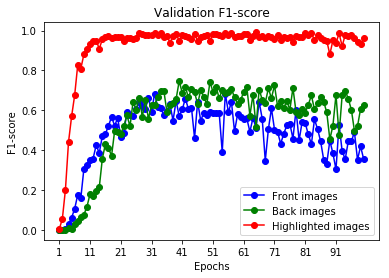

<Figure size 432x288 with 0 Axes>

In [7]:
best_front_epochs = front_f1s.index(max(front_f1s)) + 1
best_back_epochs = back_f1s.index(max(back_f1s)) + 1
best_high_epochs = high_f1s.index(max(high_f1s)) + 1

print("[Front]\t\t%d epochs reach the best f1-score value %.2f%%"%(best_front_epochs, max(front_f1s) * 100))
print("[Back]\t\t%d epochs reach the best f1-score value %.2f%%"%(best_back_epochs, max(back_f1s) * 100))
print("[Highlighted]\t%d epochs reach the best f1-score value %.2f%%"%(best_high_epochs, max(high_f1s) * 100))

plt.plot(range(100), front_f1s, 'b-o', label = 'Front images')
plt.plot(range(100), back_f1s, 'g-o', label = 'Back images')
plt.plot(range(100), high_f1s, 'r-o', label = 'Highlighted images')
plt.legend()
plt.title('Validation F1-score')
plt.xlabel('Epochs')
plt.xticks(np.arange(0, 100, step = 10), range(1, 101, 10))
plt.ylabel('F1-score')
plt.figure()

plt.show()

## Step 8. 使用完整資料重新訓練模型
根據前述的實驗結果，我將以識別效果最佳的 Epoch 次數作為訓練的 Early Stopping 時機，**採用完整的訓練資料集**（不切分驗證集），重新對相同的網路結構進行訓練。

資料總計：訓練樣本 13,500 張影像、測試樣本 4,500 張影像，共 250 類。

In [8]:
# 重新建立卷積神經網路
model_front = models.Sequential()
model_front.add(layers.Conv2D(16, (3, 3), activation = 'relu', input_shape = (image_size, image_size, 3)))
model_front.add(layers.MaxPooling2D((2, 2)))
model_front.add(Dropout(0.25))
model_front.add(layers.Conv2D(32, (3, 3), activation = 'relu'))
model_front.add(layers.MaxPooling2D((2, 2)))
model_front.add(Dropout(0.25))
model_front.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model_front.add(layers.MaxPooling2D((2, 2)))
model_front.add(Dropout(0.25))
model_front.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model_front.add(layers.MaxPooling2D((2, 2)))
model_front.add(Dropout(0.25))
model_front.add(layers.Flatten())
model_front.add(layers.Dense(128, activation = 'relu'))
model_front.add(Dropout(0.5))
model_front.add(layers.Dense(250, activation = 'softmax'))

model_back = models.Sequential()
model_back.add(layers.Conv2D(16, (3, 3), activation = 'relu', input_shape = (image_size, image_size, 3)))
model_back.add(layers.MaxPooling2D((2, 2)))
model_back.add(Dropout(0.25))
model_back.add(layers.Conv2D(32, (3, 3), activation = 'relu'))
model_back.add(layers.MaxPooling2D((2, 2)))
model_back.add(Dropout(0.25))
model_back.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model_back.add(layers.MaxPooling2D((2, 2)))
model_back.add(Dropout(0.25))
model_back.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model_back.add(layers.MaxPooling2D((2, 2)))
model_back.add(Dropout(0.25))
model_back.add(layers.Flatten())
model_back.add(layers.Dense(128, activation = 'relu'))
model_back.add(Dropout(0.5))
model_back.add(layers.Dense(250, activation = 'softmax'))

model_high = models.Sequential()
model_high.add(layers.Conv2D(16, (3, 3), activation = 'relu', input_shape = (image_size, image_size, 3)))
model_high.add(layers.MaxPooling2D((2, 2)))
model_high.add(Dropout(0.25))
model_high.add(layers.Conv2D(32, (3, 3), activation = 'relu'))
model_high.add(layers.MaxPooling2D((2, 2)))
model_high.add(Dropout(0.25))
model_high.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model_high.add(layers.MaxPooling2D((2, 2)))
model_high.add(Dropout(0.25))
model_high.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model_high.add(layers.MaxPooling2D((2, 2)))
model_high.add(Dropout(0.25))
model_high.add(layers.Flatten())
model_high.add(layers.Dense(128, activation = 'relu'))
model_high.add(Dropout(0.5))
model_high.add(layers.Dense(250, activation = 'softmax'))

# 重新編譯模型
model_front.compile(
    optimizer = 'rmsprop',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

model_back.compile(
    optimizer = 'rmsprop',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

model_high.compile(
    optimizer = 'rmsprop',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

# 重新製作數據 Generator
data_generator = ImageDataGenerator(rescale=1./255)

print("Status of front images:")

print("[Training set]")

front_train_gen = data_generator.flow_from_directory(
        front_train_dir,
        target_size = (image_size, image_size),
        shuffle = True,
        seed = 13,
        class_mode = 'categorical',
        batch_size = 36)

print("[Testing set]")

front_test_gen = data_generator.flow_from_directory(
        front_test_dir,
        target_size = (image_size, image_size),
        shuffle = True,
        seed = 13,
        class_mode = 'categorical',
        batch_size = 36)

print("\nStatus of back images:")

print("[Training set]")

back_train_gen = data_generator.flow_from_directory(
        back_train_dir,
        target_size = (image_size, image_size),
        shuffle = True,
        seed = 13,
        class_mode = 'categorical',
        batch_size = 36)

print("[Testing set]")

back_test_gen = data_generator.flow_from_directory(
        back_test_dir,
        target_size = (image_size, image_size),
        shuffle = True,
        seed = 13,
        class_mode = 'categorical',
        batch_size = 36)

print("\nStatus of highlighted images:")

print("[Training set]")

high_train_gen = data_generator.flow_from_directory(
        high_train_dir,
        target_size = (image_size, image_size),
        shuffle = True,
        seed = 13,
        class_mode = 'categorical',
        batch_size = 36)

print("[Testing set]")

high_test_gen = data_generator.flow_from_directory(
        high_test_dir,
        target_size = (image_size, image_size),
        shuffle = True,
        seed = 13,
        class_mode = 'categorical',
        batch_size = 36)

# 設定 Callback 函式並在訓練完成時，計算測試資料集的 F1-score
test_f1s = []

class MetricsFront(Callback):

    def __init__(self, test_data = front_test_gen, batch_size = 36):
        super().__init__()
        self.test_data = test_data
        self.batch_size = batch_size
        
    def on_train_end(self, epoch, logs={}):
        batches = len(self.test_data)
        total = batches * self.batch_size
        
        test_pred = np.zeros((total, 250))
        test_true = np.zeros((total, 250))
        
        for batch in range(batches):
            xTest, yTest = next(self.test_data)
            test_pred[batch * self.batch_size : (batch + 1) * self.batch_size] = np.asarray(self.model.predict(xTest)).round()
            test_true[batch * self.batch_size : (batch + 1) * self.batch_size] = yTest
            
        test_pred = np.squeeze(test_pred)
        _test_f1 = f1_score(test_true, test_pred, average = 'micro')
        test_f1s.append(_test_f1)
        
        return
    
class MetricsBack(Callback):

    def __init__(self, test_data = back_test_gen, batch_size = 36):
        super().__init__()
        self.test_data = test_data
        self.batch_size = batch_size
        
    def on_train_end(self, epoch, logs={}):
        batches = len(self.test_data)
        total = batches * self.batch_size
        
        test_pred = np.zeros((total, 250))
        test_true = np.zeros((total, 250))
        
        for batch in range(batches):
            xTest, yTest = next(self.test_data)
            test_pred[batch * self.batch_size : (batch + 1) * self.batch_size] = np.asarray(self.model.predict(xTest)).round()
            test_true[batch * self.batch_size : (batch + 1) * self.batch_size] = yTest
            
        test_pred = np.squeeze(test_pred)
        _test_f1 = f1_score(test_true, test_pred, average = 'micro')
        test_f1s.append(_test_f1)
        
        return
    
class MetricsHigh(Callback):

    def __init__(self, test_data = high_test_gen, batch_size = 36):
        super().__init__()
        self.test_data = test_data
        self.batch_size = batch_size
        
    def on_train_end(self, epoch, logs={}):
        batches = len(self.test_data)
        total = batches * self.batch_size
        
        test_pred = np.zeros((total, 250))
        test_true = np.zeros((total, 250))
        
        for batch in range(batches):
            xTest, yTest = next(self.test_data)
            test_pred[batch * self.batch_size : (batch + 1) * self.batch_size] = np.asarray(self.model.predict(xTest)).round()
            test_true[batch * self.batch_size : (batch + 1) * self.batch_size] = yTest
            
        test_pred = np.squeeze(test_pred)
        _test_f1 = f1_score(test_true, test_pred, average = 'micro')
        test_f1s.append(_test_f1)

        return
    
# 重新訓練深度學習網路
print("\nFront images training:")

model_front.fit_generator(
    front_train_gen,
    steps_per_epoch = 375,
    epochs = best_front_epochs,
    callbacks = [MetricsFront()])

print("\nBack images training:")

model_back.fit_generator(
    back_train_gen,
    steps_per_epoch = 375,
    epochs = best_back_epochs,
    callbacks = [MetricsBack()])

print("\nHighlighted images training:")

model_high.fit_generator(
    high_train_gen,
    steps_per_epoch = 375,
    epochs = best_high_epochs,
    callbacks = [MetricsHigh()])

Status of front images:
[Training set]
Found 13500 images belonging to 250 classes.
[Testing set]
Found 4500 images belonging to 250 classes.

Status of back images:
[Training set]
Found 13500 images belonging to 250 classes.
[Testing set]
Found 4500 images belonging to 250 classes.

Status of highlighted images:
[Training set]
Found 13500 images belonging to 250 classes.
[Testing set]
Found 4500 images belonging to 250 classes.

Front images training:
Epoch 1/32
375/375 [==============================] - 134s 356ms/step - loss: 5.3787 - acc: 0.0080
Epoch 2/32
375/375 [==============================] - 133s 355ms/step - loss: 4.9128 - acc: 0.0280
Epoch 3/32
375/375 [==============================] - 133s 354ms/step - loss: 4.2981 - acc: 0.0744
Epoch 4/32
375/375 [==============================] - 134s 357ms/step - loss: 3.7502 - acc: 0.1377
Epoch 5/32
375/375 [==============================] - 134s 357ms/step - loss: 3.2850 - acc: 0.1989
Epoch 6/32
375/375 [============================

375/375 [==============================] - 109s 291ms/step - loss: 1.1748 - acc: 0.6784
Epoch 7/65
375/375 [==============================] - 109s 292ms/step - loss: 0.9672 - acc: 0.7270
Epoch 8/65
375/375 [==============================] - 110s 293ms/step - loss: 0.8095 - acc: 0.7696
Epoch 9/65
375/375 [==============================] - 111s 295ms/step - loss: 0.6751 - acc: 0.8032
Epoch 10/65
375/375 [==============================] - 110s 295ms/step - loss: 0.5965 - acc: 0.8235
Epoch 11/65
375/375 [==============================] - 111s 295ms/step - loss: 0.5523 - acc: 0.8407
Epoch 12/65
375/375 [==============================] - 110s 293ms/step - loss: 0.4882 - acc: 0.8565
Epoch 13/65
375/375 [==============================] - 109s 291ms/step - loss: 0.4277 - acc: 0.8737
Epoch 14/65
375/375 [==============================] - 109s 291ms/step - loss: 0.4072 - acc: 0.8816
Epoch 15/65
375/375 [==============================] - 109s 291ms/step - loss: 0.3710 - acc: 0.8896
Epoch 16/65
375

## 實驗總結
排藥正面與背面影像，在測試資料集上僅能達到 67.43% 與 50.73% 的識別效果；而雙面拼整影像則達到了 98.53%。

這些現象都可證明「誘導式深度學習」技術，對於樣本稀少、外觀相似且種類繁多的排藥辨識問題，不但能提供實際且有效的解決方案，還能套用於任何一種深度學習網路結構，使該網路的特徵學習與識別能力大幅提升。

In [9]:
print("--- TESTING RESULT ---")
print("[Front]\t\tThe f1-score of front testing set: %.2f%%"%(test_f1s[0] * 100))
print("[Back]\t\tThe f1-score of back testing set: %.2f%%"%(test_f1s[1] * 100))
print("[Highlighted]\tThe f1-score of highlighted testing set: %.2f%%"%(test_f1s[2] * 100))

--- TESTING RESULT ---
[Front]		The f1-score of front testing set: 58.52%
[Back]		The f1-score of back testing set: 75.79%
[Highlighted]	The f1-score of highlighted testing set: 97.94%
